## Проект "Парсинг сайта "eda.ru", анализ значений коэффициента корреляции Пирсона, построение графиков, а также создание модели поиска интересующего блюда"

## Кто не любит есть? Все любят есть!
Да, мы тоже любим есть, поэтому мы выбрали сайт: https://eda.ru/! А еще мы студенты и не любим готовить, поэтому, если и выбирать рецепты, то простые и вкусные. А еще нам хочется, чтобы блюдо имело достаточн калорий, чтобы мы наелись, а также, чтобы была также возможность выбрать блюдо по лайкам, стране и его типу! Столько всего хочется!

Выбранный нами сайт предоставляет возможности удобно вычленять данные, у него отличный и понятный интерфейс, разделения по категориям и хорошие рецепты (что важно!). 

Сайт не предоставляет таких широких возможностей поиска блюд, несмотря на возможности его оптимизировать. Поэтому спарсить данные в данном случае представляется очень актуальной идеей. Если рассматривать цель проекта с точки зрения более прикладных задач, то можно выбирать основные блюда на мероприятия компании с точки зрения калорийности (если вы ивент-менеджер, ну вдруг...) Также, данный проект будет полезен для жителей Дубков, которые часто не хотят заморачиваться с выбором блюд! В дальнейшем можно создать бота по студенческим рецептам, увеличив выборку :)

### Что мы планируем сделать?
Так как мы хотим поесть сытные блюда, то для парсинга мы взяли рецепты из категории "основные блюда", что отразилось и в ссылке. Всего на сайте есть около 19 тысяч рецептов основных блюд, поэтому нами было принято решение собрать данные с первых пятидесяти страниц. С этих страниц мы вычленяем ссылки на рецепты. Далее проходимся по каждой ссылке и собираем оттуда нужную нам информацию (название, время приготовления, количество калорий, лайки и тип блюда).

## Что мы для этого используем?
Для web-scrapping нам понадобилось: библиотека requests - для вычленения html-разметки с веб-страницы, библиотека BeatifulSoup - для структурирования полученной разметки.

Опишем этапы разработки кода:

1. Создание собственной функции get_dishes, которая определяет количество страниц внутри основных рецептов, которые мы "листаем" вниз. Так как это функция, пользователь может прописать любое количество страниц, и тем самым уменьшить или увеличить выборку. Для нашего датасета мы взяли 50 страниц (что грузилось около часа, поэтому впоследствии мы выгрузили их в xlsx-файл для удобства работы с разных устройств).

2. С помощью тега "а" ищем все ссылки через find_all, с помощью get('href') вычленяем объекты, содержащие ссылки и с помощью проверки "if" добавляем в ранее созданный список "recipes" ссылки с "/recepty/osnovnye-blyuda/", но без "ingredienty"(так как на тех ссылках находилась сторонняя информация).

3. Далее создаем пустой список data для кортежей с информацией про блюда. Проходимся по списку recipes. Используем try/except для того, чтобы исключить ошибку, которая возникла в процессе кода ("ChunkedEncodingError"), а также потенциальные ощибки, связанные с индексацией. Далее снова работаем с BeautifulSoup и находим интересующие нас теги со страниц. Вычленяем название блюда, время приготовления, количество калорий, количество лайков на рецепте, кухню, к которой принадлежит блюдо, и тип блюда. Любопытно было вычленить время и конвертировать все значения в минуты. Дело в том, что в некоторых рецептах время приготовления было записано в формате "1 час" или, например, "1 час 20 минут".

4. Применяем нашу функцию get_dishes (к 50 страницам). Итого в data содержится информация о 433 блюдах.

5. Импортируем библиотеку pandas, создаем датафрейм из каждого блюда и добавляем его в общий датафрейм "all_dishes". Называем столбцы датафрейма так, как нам неоюходимо ('Название','Время приготовления','Калории','Лайки','Кухня','Тип')

6. Преобразуем датафрейм в xlsx-файл "all_dishes".

In [1]:
def get_dishes(pages):

    import requests
    from bs4 import BeautifulSoup

    recipes = []
    
    for page in range(pages):
        url = f'https://eda.ru/recepty/osnovnye-blyuda?page={page}'
        try:
            html = requests.get(url)
        except requests.exceptions.ChunkedEncodingError:
            continue

        soup = BeautifulSoup(html.text)

        for link in soup.find_all("a"):
            href = link.get('href')
            if href.startswith('/recepty/osnovnye-blyuda/') and "ingredienty" not in href:
                if 'https://eda.ru' + href not in recipes:
                    recipes.append('https://eda.ru' + href)

    data = []
    
    for i in recipes:
        url = i
        try:
            html = requests.get(url)
        except requests.exceptions.ChunkedEncodingError:
            continue

        soup = BeautifulSoup(html.text)
        
        try:
            name = soup.find('h1', {"class":"emotion-gl52ge"})
            if name is not None:
                name = name.text.replace("\xa0", " ")
        except:
            continue

        try:
            cals = soup.find('span', {"itemprop":"calories"})
            if cals is not None:
                cals = int(cals.text)
        except:
            continue

        try:
            time = soup.find('div', {"class":"emotion-my9yfq"})
            if time is not None:
                time = time.text

                if "минут" in (time.split("  "))[0].split(" ")[1]:
                    time = int(time.split("  ")[0].split(" ")[0])
                elif len(time.split("  ")) == 1 and "час" in (time.split("  "))[0].split(" ")[1]:
                    time = int(time.split("  ")[0].split(" ")[0])*60
                elif len(time.split("  ")) > 1 and "час" in (time.split("  "))[0].split(" ")[1]:
                    time = int(time.split("  ")[0].split(" ")[0])*60 + int(time.split("  ")[1].split(" ")[0])
        except:
            continue

        try:
            likes = soup.find('span', {"class":"emotion-a07nxg"})
            if likes is not None:
                likes = int(likes.text)
        except:
            continue

        try:
            cuisine = soup.find_all('span', {"class":"emotion-1h6i17m"})[2]
            if cuisine is not None:
                cuisine = cuisine.text
        except:
            continue

        try:
            class_re = soup.find_all('span', class_='emotion-1h6i17m')[4]
            if class_re is not None:
                class_re = class_re.text.strip()
        
        except:
            continue

        dish = (name, time, cals, likes, cuisine, class_re)

        if "рецепты" not in class_re.lower() and "идеи" not in class_re.lower() and "вопрос" not in class_re.lower() and "путешествия" not in class_re.lower():
            data.append(dish)
        
    return data

dishes = get_dishes(50)

import pandas as pd

all_dishes = pd.DataFrame()

for i in dishes:
    one_dish = pd.DataFrame(i).transpose()
    all_dishes = pd.concat([all_dishes, one_dish])

all_dishes.columns = ['Название','Время приготовления','Калории','Лайки','Кухня','Тип']

all_dishes.to_excel('all_dishes.xlsx')

## Здесь можно увидеть выдачу датафрейма all_dishes

433 ряда и 7 столбцов

In [156]:
all_dishes

,Unnamed: 0,Название,Время приготовления,Калории,Лайки,Кухня,Тип
0,0,Лимонный цыпленок с орзо,45,671,1,Еврейская кухня,Блюда из курицы
1,0,Мексиканское блюдо из фасоли и говяжьего фарша,20,526,10,Мексиканская кухня,Блюда с фаршем
2,0,"Острое блюдо из нута, томатов и шпината",40,317,2,Европейская кухня,Горячие закуски
3,0,Вегетарианское блюдо чили за 15 минут,15,239,1,Европейская кухня,Горячие закуски
4,0,Вегетарианское блюдо из фасоли и бобов с чили ...,375,300,1,Европейская кухня,Горячие закуски
...,...,...,...,...,...,...,...
428,0,Кордон блю из стейка индейки с ветчиной Кампана,90,594,2,Французская кухня,Котлеты
429,0,Фрикасе из кролика с оливками,150,520,2,Французская кухня,Блюда из мяса
430,0,Стейк из цветной капусты с киноа и зеленым соусом,60,736,2,Авторская кухня,Блюда из овощей
431,0,Свинина с горчицей и пряностями,40,473,75,Паназиатская кухня,Здоровье


## Для удобства мы прогнали код и сохранили наш полученный файл в репозиторий на GitHub. Это позволило нам всем удаленно работать с файлом, не запуская код для создания xlsx-файла снова и снова.

Поэтому мы вновь импортируем библиотеку pandas.

In [157]:
import pandas as pd

Считываем наш файл, предварительно преобразованный из xlsx в tsv, из репозитория на GitHub

In [158]:
all_dishes = pd.read_csv("https://raw.githubusercontent.com/dapivovarov/forpython/main/all_dishes%20(2).tsv", sep='\t')

В ходе предварительного осмотра данных мы заметили аномально большие значения, которые удалили с помощью drop.

In [159]:
all_dishes = all_dishes.drop(labels = [291],axis = 0)
all_dishes = all_dishes.drop(labels = [5],axis = 0)

# Построение и визуализация корреляционных коэффициентов

Для подсчета корреляции мы решили создать новую функцию, в которую загрузили два количественных признака, между которыми хотели проследить связь.

In [161]:
def correlation(first_c, second_c):
    from scipy import stats
    return stats.pearsonr(all_dishes[first_c], all_dishes[second_c])

Предварительно мы сформировали гипотезы. 

1) Мы считали, что время приготовления имеет обратную связь с лайками, так как гипотетически казалось, что люди склонны положительно оценивать рецепты, которые занимают мало времени для приготовления блюда;

2) Мы считали, что время приготовления имеет обратную связь с калориями, так как гипотетически казалось, что более калорийные блюда будут готовиться дольше;

3) Мы считали, что время количество калорий имеет прямую связь с лайками, так как гипотетически казалось, что люди склонны положительно оценивать рецепты, которые более калорийны.

In [258]:
correlation("Время приготовления", "Лайки")

PearsonRResult(statistic=-0.08959856301250789, pvalue=0.06310486886759051)

Примем уровень значимости на уровне 5%. p-value > уровня значимости. Исходя из полученного коэффициента Пирсона и p-value, можно сказать, что линейная связь между временем приготовления и количеством лайков практически отсутствует. При данном уровне значимости у нас нет оснований считать выводы статистически значимыми.

In [259]:
correlation("Время приготовления", "Калории")

PearsonRResult(statistic=0.11369300963527766, pvalue=0.018219141994804382)

Примем уровень значимости на уровне 5%. p-value < уровня значимости. Исходя из полученного коэффициента Пирсона и p-value, можно сказать, что связь между временем приготовления и количеством калорий прямая, но слабая. При данном уровне значимости у нас есть основания считать выводы статистически значимыми, поэтому корреляция очень слабая, и связь почти отсутствует.

In [260]:
correlation("Лайки", "Калории")

PearsonRResult(statistic=-0.12418198746777283, pvalue=0.00986304955369849)

Примем уровень значимости на уровне 5%. p-value < уровень значимости. Исходя из полученного коэффициента Пирсона, можно сказать, что связь между количеством лайков и калорий обратная и очень слабая. При данном уровне значимости у нас есть основания считать выводы статистически значимыми, поэтому корреляция очень слабая, и связь почти отсутствует.

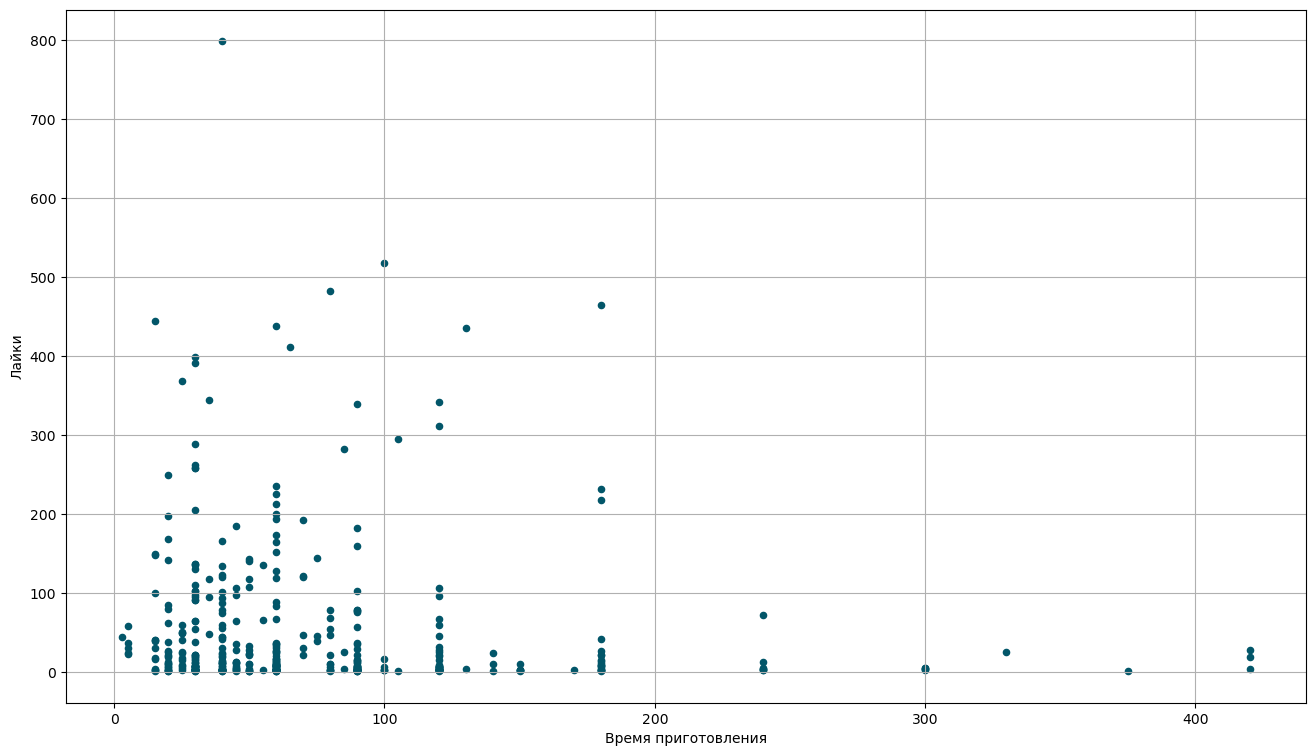

In [263]:
all_dishes.plot.scatter(x = "Время приготовления",
                   y = "Лайки",
                   color = "#025669",
                   figsize = (16, 9),
                   grid = True,
                   xlabel = "Время приготовления",
                   ylabel = "Лайки");

#### Здесь на диаграмме рассеяния наглядно видно, что линейная связь отсутствует, так как точки рассредоточены по плоскости. Тем не менее, что любопытно, можно заметить, что многие точки сосредоточены у привычных временных значений (5 минут, 15 минут и т.п).

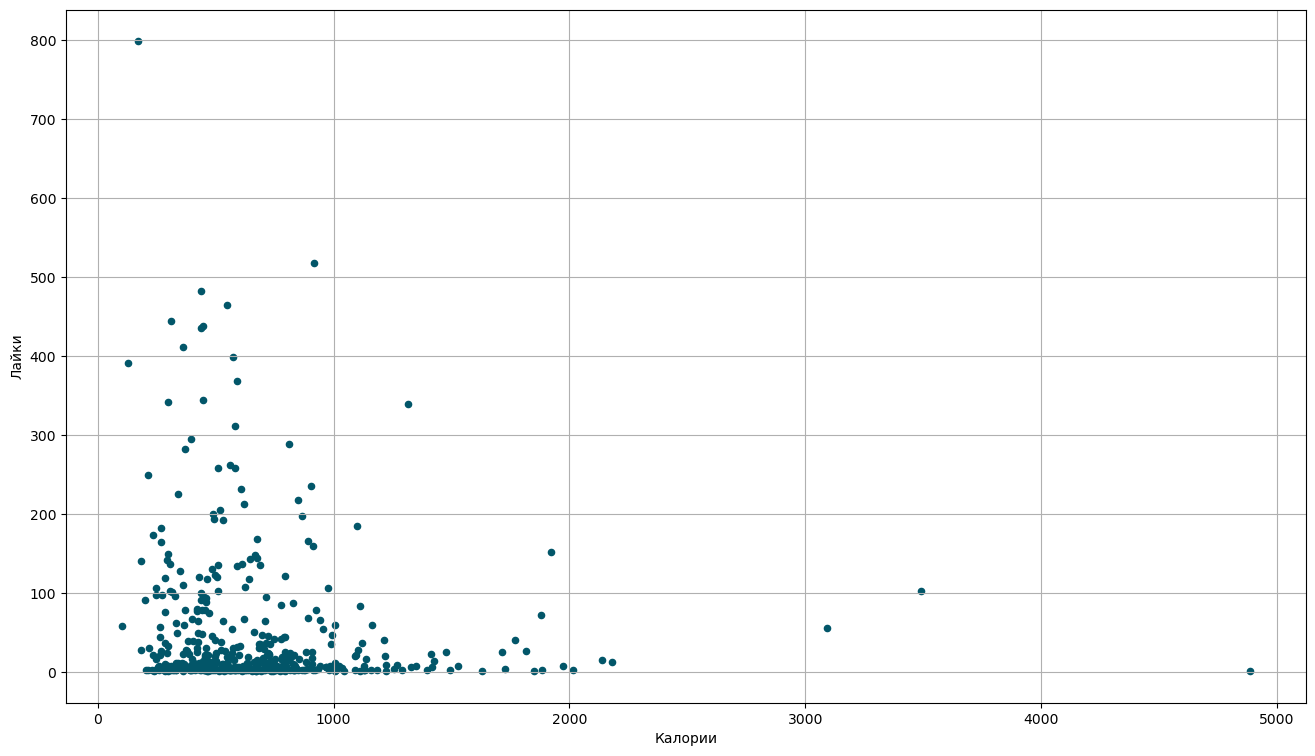

In [262]:
all_dishes.plot.scatter(x = "Калории",
                   y = "Лайки",
                   color = "#025669",
                   figsize = (16, 9),
                   grid = True,
                   xlabel = "Калории",
                   ylabel = "Лайки");

#### Здесь на диаграмме рассеяния также наглядно видно, что линейная связь отсутствует.

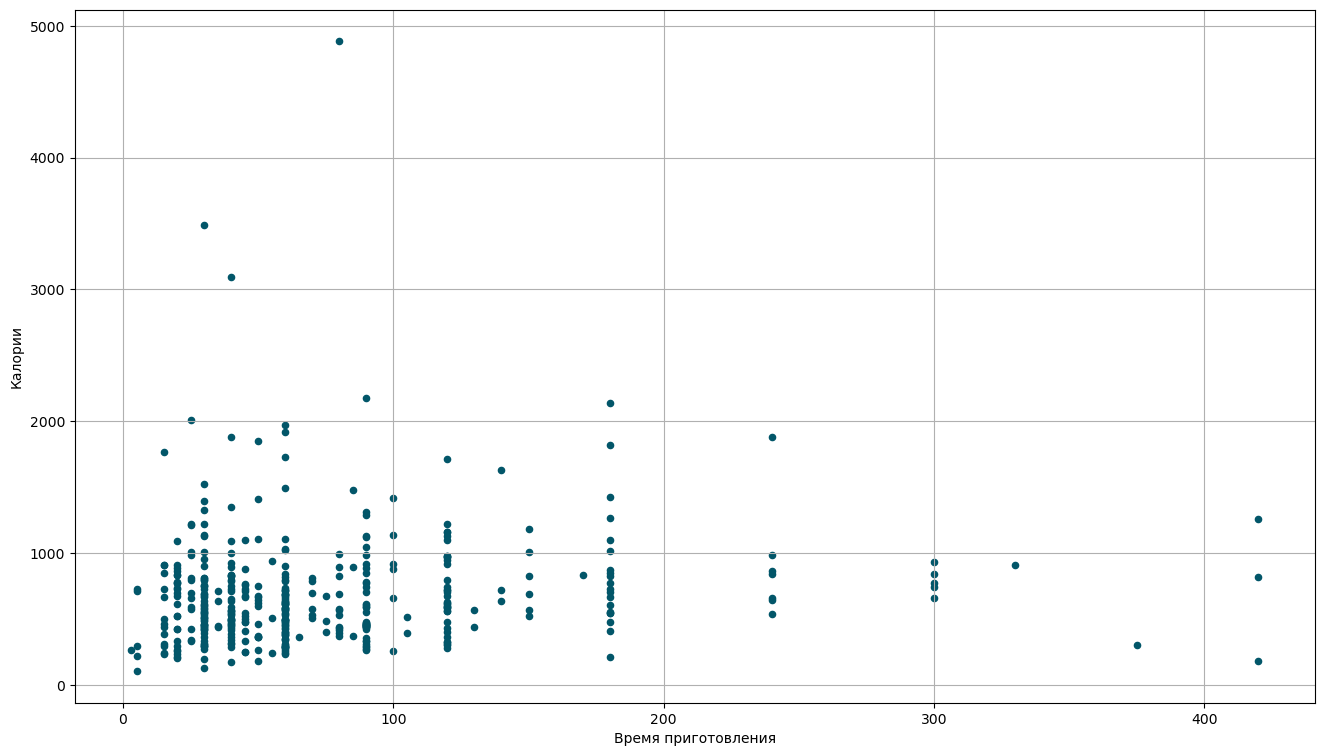

In [264]:
all_dishes.plot.scatter(x = "Время приготовления",
                   y = "Калории",
                   color = "#025669",
                   figsize = (16, 9),
                   grid = True,
                   xlabel = "Время приготовления",
                   ylabel = "Калории");

#### Здесь на диаграмме рассеяния также наглядно видно, что линейная связь отсутствует, так как точки рассредоточены по плоскости. Тем не менее, опять-таки, можно заметить, что многие точки сосредоточены у привычных временных значений (5 минут, 15 минут и т.п).

# Систематизация данных с помощью диаграмм (зависимость значений количественных переменных от качественных)

#### Используя библиотеку plotly.express, создаем диграммы типа bar, где значения рассортированы по убыванию

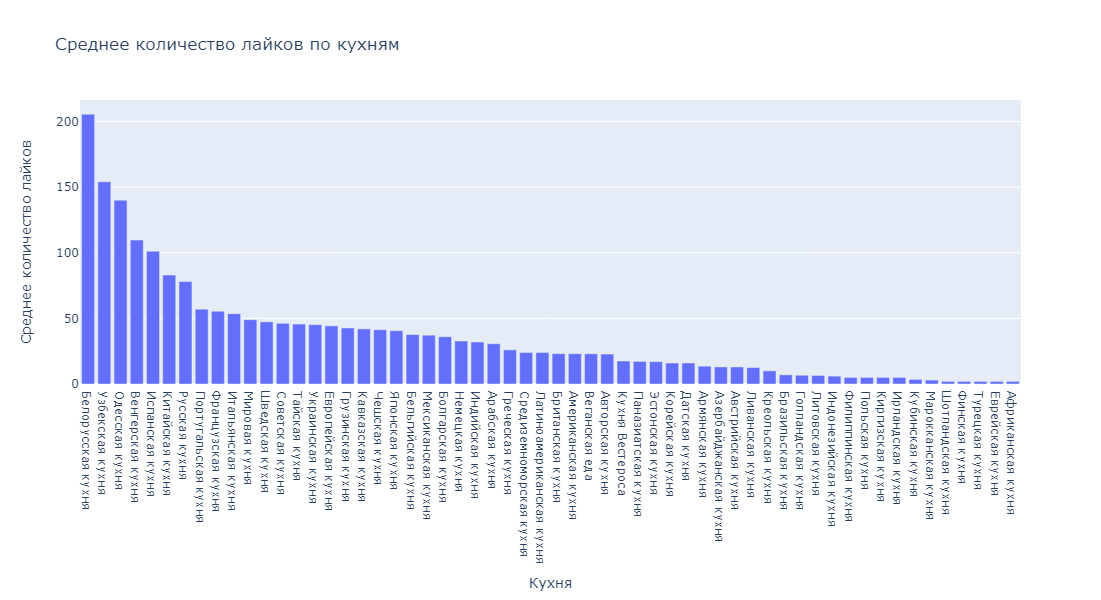

In [265]:
likes_by_cuisine = all_dishes.groupby('Кухня')['Лайки'].mean().reset_index()

import plotly.express as px
fig = px.bar(likes_by_cuisine, x='Кухня', y='Лайки',              title='Среднее количество лайков по кухням', 
             labels={'Лайки': 'Среднее количество лайков', 'Кухня': 'Кухня'},                          template='plotly')

fig.update_layout(xaxis_categoryorder='total descending', bargap=0.2) 
fig.update_layout(width=1200, height=600)

fig.show()

Таким образом, можно заключить, что кухни с самым большим количеством лайков на одно блюдо являются "Белорусская кухня", "Узбекская кухня" и "Одесская кухня"

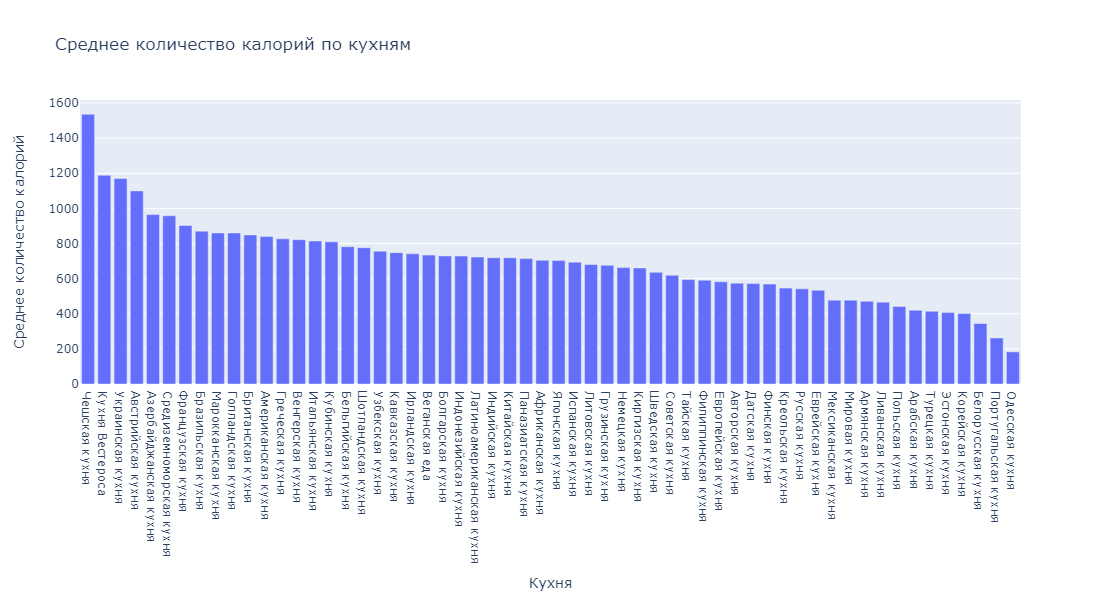

In [168]:
likes_by_cuisine = all_dishes.groupby('Кухня')['Калории'].mean().reset_index()

import plotly.express as px
fig = px.bar(likes_by_cuisine, x='Кухня', y='Калории',              title='Среднее количество калорий по кухням', 
             labels={'Калории': 'Среднее количество калорий', 'Кухня': 'Кухня'},                          template='plotly')

fig.update_layout(xaxis_categoryorder='total descending', bargap=0.2) 
fig.update_layout(width=1200, height=600)

fig.show()

Таким образом, можно заключить, что кухни с самым большим количеством калорий на одно блюдо являются "Чешская кухня", "Кухня Вестероса" и "Украинская кухня"

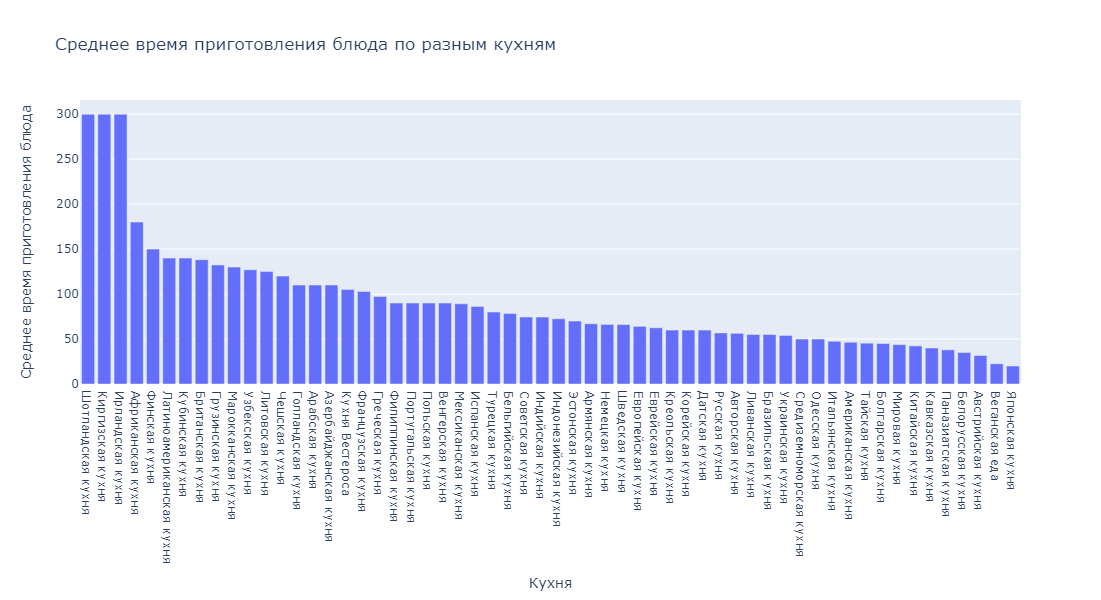

In [169]:
likes_by_cuisine = all_dishes.groupby('Кухня')['Время приготовления'].mean().reset_index()

import plotly.express as px
fig = px.bar(likes_by_cuisine, x='Кухня', y='Время приготовления',              title='Среднее время приготовления блюда по разным кухням', 
             labels={'Время приготовления': 'Среднее время приготовления блюда', 'Кухня': 'Кухня'},                          template='plotly')

fig.update_layout(xaxis_categoryorder='total descending', bargap=0.2) 
fig.update_layout(width=1200, height=600)

fig.show()

Таким образом, можно заключить, что кухни с самым большим количеством калорий на одно блюдо являются "Ирландская кухня", "Киргизская кухня" и "Шотландская кухня"

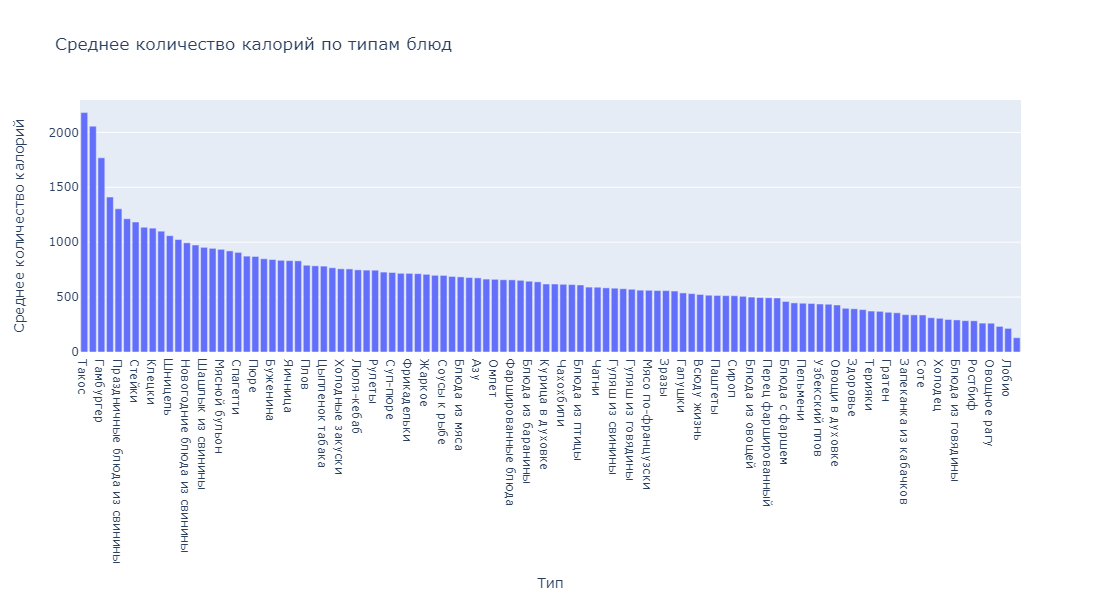

In [170]:
likes_by_cuisine = all_dishes.groupby('Тип')['Калории'].mean().reset_index()

import plotly.express as px
fig = px.bar(likes_by_cuisine, x='Тип', y='Калории',              title='Среднее количество калорий по типам блюд', 
             labels={'Калории': 'Среднее количество калорий', 'Тип': 'Тип'},                          template='plotly')

fig.update_layout(xaxis_categoryorder='total descending', bargap=0.2) 
fig.update_layout(width=1200, height=600)

fig.show()

Таким образом, можно заключить, что типами с самым большим количеством калорий на одно блюдо являются "Такос", "Киевские котлеты" и "Гамбургер"

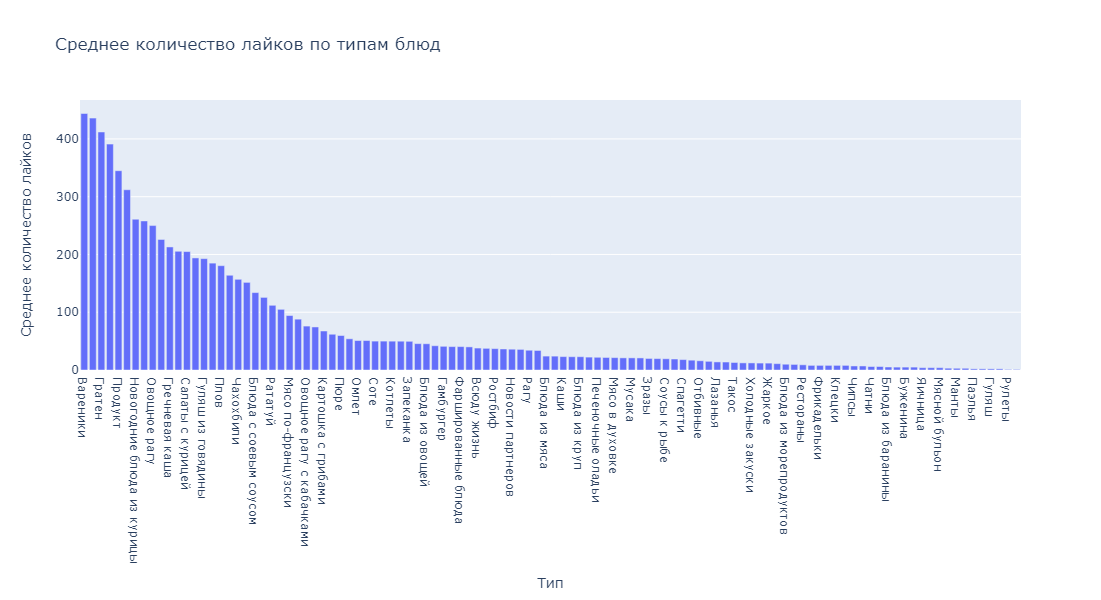

In [171]:
likes_by_cuisine = all_dishes.groupby('Тип')['Лайки'].mean().reset_index()

import plotly.express as px
fig = px.bar(likes_by_cuisine, x='Тип', y='Лайки',              title='Среднее количество лайков по типам блюд', 
             labels={'Лайки': 'Среднее количество лайков', 'Тип': 'Тип'},                          template='plotly')

fig.update_layout(xaxis_categoryorder='total descending', bargap=0.2) 
fig.update_layout(width=1200, height=600)

fig.show()

Таким образом, можно заключить, что типами с самым большим количеством лайков на одно блюдо являются "Вареники", "Узбекский плов" и "Гратен"

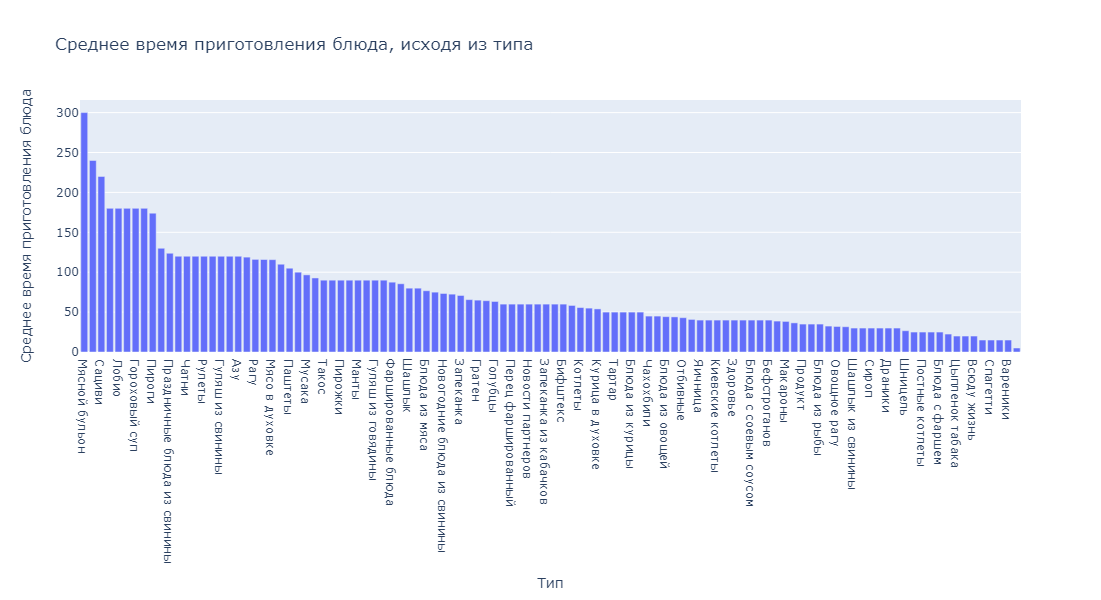

In [172]:
likes_by_cuisine = all_dishes.groupby('Тип')['Время приготовления'].mean().reset_index()

import plotly.express as px
fig = px.bar(likes_by_cuisine, x='Тип', y='Время приготовления',              title='Среднее время приготовления блюда, исходя из типа', 
             labels={'Время приготовления': 'Среднее время приготовления блюда', 'Тип': 'Тип'},                          template='plotly')

fig.update_layout(xaxis_categoryorder='total descending', bargap=0.2) 
fig.update_layout(width=1500, height=600) 

fig.show()

Таким образом, можно заключить, что типами с самым большим временем приготовления на одно блюдо являются "Мясной бульон", "Буженина" и "Сациви"

# Создание модели поиска интересующего блюда

Мы решили озадачиться кое-чем ещё и придумали, как нам можно, исходя из наших данных, создать что-то наподобие приложения для поиска нужного рецепта с сайта eda.ru

Приложение просит ввести нужные характеристики (кухню, максимальное время приготовления, минимальное и максимальное количество калорий), а на выходе выдает датафрейм со всеми блюдами, попадающими под критерии. Блюда размещены по лайкам по убыванию.

In [267]:
def finder():
    print("Введите кухню, блюдо из которой хотите попробовать")
    cuis = input()
    print("Введите максимальное время, которое вы готовы потратить на приготовление")
    max_time = int(input())
    print("Введите минимальное количество калорий в блюде, которое вы хотите приготовить")
    min_cals = int(input())
    print("Введите максимальное количество калорий в блюде, которые вы хотите приготовить")
    maxi_cals = int(input())

    new_df = all_dishes[(all_dishes['Кухня'] == cuis) 
    & (all_dishes['Время приготовления'] <= max_time)
    & (all_dishes['Калории'] >= min_cals)
    & (all_dishes['Калории'] <= maxi_cals)]

    return new_df.sort_values(by='Лайки', ascending=False)

finder()

Введите кухню, блюдо из которой хотите попробовать


 Русская кухня


Введите максимальное время, которое вы готовы потратить на приготовление


 56


Введите минимальное количество калорий в блюде, которое вы хотите приготовить


 450


Введите максимальное количество калорий в блюде, которые вы хотите приготовить


 500


,Unnamed: 0,Название,Время приготовления,Калории,Лайки,Кухня,Тип
324,0,Запеканка картофельная,30,451,95,Русская кухня,Запеканка
99,0,Макароны с сыром,30,454,22,Русская кухня,Макароны
308,0,Гречка с курицей,30,462,3,Русская кухня,Каши
327,0,Картошка с тушенкой,40,490,3,Русская кухня,Жаркое
